In [2]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

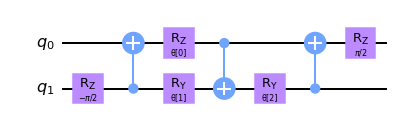

In [4]:
# We now define a two qubit unitary as defined in [3]
def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl")

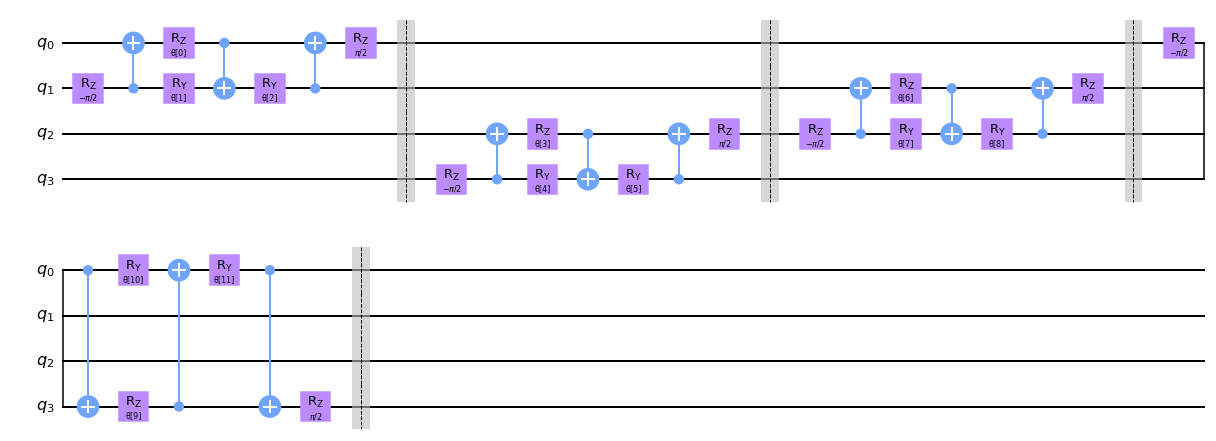

In [5]:
def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl")

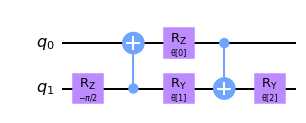

In [6]:
def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl")

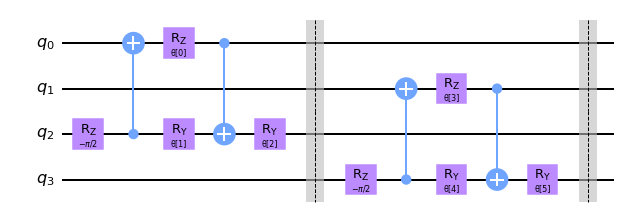

In [7]:
def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc


sources = [0, 1]
sinks = [2, 3]
circuit = pool_layer(sources, sinks, "θ")
circuit.decompose().draw("mpl")

In [ ]:
import qiskit as qsk
import numpy as np
import skimage
from skimage.transform import resize

def make_circuit(image, n=16):
    circuit = qsk.QuantumCircuit(n,n)
    for i in range(n):
        for j in range(n):
            if i == j:
                circuit.rx(image[i][i],i)
            else:
                circuit.crx(image[i][j],i,j) #pixel (1,0)
    return(circuit)

def make_parametrized_circuit(n=16):
    circuit = qsk.QuantumCircuit(n,n)
    
    p = ParameterVector('p', 256)
    
    for i in range(n):
        for j in range(n):
            if i == j:
                circuit.rx(p[i*n+j],i)
            else:
                circuit.crx(p[i*n+j],i,j) #pixel (1,0)
    return(circuit)

def angle_parametrized_circuit(n):
    circuit = QuantumCircuit(n/2)

    p = ParameterVector('p', n)

    for i in range(0,n,2):
        circuit.rx(p[i],int(i/2))
        circuit.ry(p[i+1],int(i/2))

    return(circuit)

def encode(image):
    image_resized = resize(image, (16, 16))
    return(make_circuit(image_resized))

In [ ]:
qc=angle_parametrized_circuit(8)
qc.draw()

In [ ]:
def resize(image, kernel_dim=2):
    M, N = image.shape
    MK = M // kernel_dim
    NL = N // kernel_dim
    return image[:MK*kernel_dim, :NL*kernel_dim].reshape(MK, kernel_dim, NL, kernel_dim).max(axis=(1, 3))

In [ ]:
images=np.load('images.npy')
labels=np.load('labels.npy')

images = images*255*3.14/2

In [ ]:
def preprocess(images, labels, size, pool_size=2):
    images_cut = images[0:len(images), 0:16, 3:7]

    sequence = np.arange(0,2000)
    np.random.shuffle(sequence)

    images_25 = [resize(images_cut[sequence[i]], pool_size).flatten() for i in range(size)]
    images_show = [images[sequence[i]] for i in range(size)]
    labels_25 = [2*int(labels[sequence[i]]==True)-1 for i in range(2000)]

    return images_25, labels_25, images_show

images_25, labels_25, images_show = preprocess(images, labels, 2000, 2)

In [ ]:
train_images, test_images, train_labels, test_labels = train_test_split(
    images_25, labels_25, test_size=0.3
)

In [ ]:
feature_map = angle_parametrized_circuit(16)

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "с1"), list(range(8)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)

# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4,8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4,8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6,8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6,8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=200),  # Set max iterations here
    callback=callback_graph,
)

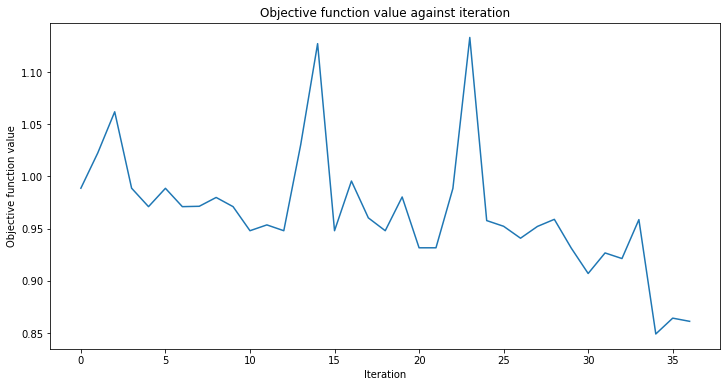

In [ ]:
%%time
x = np.asarray(train_images)
y = np.asarray(train_labels)

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
classifier.fit(x, y)

# score classifier
print(f"Accuracy from the train data : {np.round(100 * classifier.score(x, y), 2)}%")

In [19]:
x_test = np.asarray(test_images)
y_test = np.asarray(test_labels)

# score classifier
print(f"Accuracy from the test data : {np.round(100 * classifier.score(x_test, y_test), 2)}%")

Accuracy from the train data : 22.17%
